# Prepare input data for ClimateBench

#### Changes
    - fixed environment (xesmf)
    - added paths
    - changed splitting
    
#### Problems
    - conservative regridding
    - historical preparation

In [1]:
import tarfile
import os.path
import numpy as np
import xesmf as xe
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from glob import glob

In [3]:
# Data paths on JASMIN
input_path = '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/' # data from Duncan
path_f = input_path+'/{species}*-{scenario}-1-1_gn*.nc'
#path_f=input_path+'*{scenario}_*.nc'
output_path = '/home/charlie/Documents/MILA/ClimateBench/target_data/prepared_data/'
path_f_csv = input_path+'/{species}*-{scenario}-1-1_gn*.csv'

In [4]:
experiments = [
               'ssp370', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF', 'ssp585' #	ScenarioMIP
]

In [5]:
# All units are in kg m-2 s-1
# Convert to GtC -> multiply by area of earth, period I've summed, and divide by weight of carbon
AREA_OF_EARTH = 5.101e+14 #m2
SECONDS_IN_YEAR = 60*60*24*365 #s
MASS_OF_CARBON = 1.9944235e-26  #kg
FRACTION_OF_CARBON_MASS = (6) / (6 + 8 + 8)

convert = lambda x: x * AREA_OF_EARTH * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

def global_mean(ds):
    if 'plev' in ds.coords:
        res = ds.sum('plev')
    else:
        res = ds
        
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    gl_mean = res.weighted(weights).mean(("lon", "lat"))
    
    return gl_mean

def global_sum(ds):
    if 'plev' in ds.coords:
        res = ds.sum('plev')
    else:
        res = ds
        
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    gl_total = res.weighted(weights).sum(("lon", "lat")) * AREA_OF_EARTH
    
    return gl_total

# Setup regridding

In [6]:
# Example NorESM grid
noresm_grid = xr.open_dataset(input_path+'/NorESM2-LM_hist-GHG_r1i1p1f1.nc')
#print(noresm_grid['lon_bnds'])
#print(noresm_grid.keys())
print(noresm_grid)
# Example input4MIPS grid
#rename_dict={'lon_bnds': 'lon_b', 'lat_bnds': 'lat_b'}
#noresm_grid.rename_vars(lon_bnds='lon_b', lat_bnds='lat_b', inplace=True) 
example_input4MIPs_ds = xr.open_mfdataset(path_f.format(species="CO2", scenario='ssp370'), combine='by_coords').sum('sector')
#example_input4MIPs_ds = xr.open_mfdataset(input_path+'NorESM2-LM_ssp370_r2i1p1f1.nc', combine='by_coords').sum('sector')
print(example_input4MIPs_ds)
# conservative does not work as we have no corner informaion, switching to 'bilinear'
# //TODO: fix?
#regridder = xe.Regridder(example_input4MIPs_ds, noresm_grid.rename({'lat': 'latitude', 'lon': 'longitude'}), 'bilinear', periodic=True)
regridder = xe.Regridder(example_input4MIPs_ds, noresm_grid, 'bilinear', periodic=True)

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, year: 171)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * year                       (year) int64 1850 1851 1852 ... 2018 2019 2020
    quantile                   float64 ...
Data variables:
    diurnal_temperature_range  (year, lat, lon) float32 ...
    tas                        (year, lat, lon) float32 ...
    pr                         (year, lat, lon) float32 ...
    pr90                       (year, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 120, bound: 2)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
Dimensions without coordinates: bound
Data variables

In [7]:
print(regridder)
coarse_emissions_t = regridder(example_input4MIPs_ds['CO2_em_anthro'])
print(coarse_emissions_t)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_96x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 720) 
Output grid shape:          (96, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True
<xarray.DataArray 'CO2_em_anthro' (time: 120, lat: 96, lon: 144)>
dask.array<transpose, shape=(120, 96, 144), dtype=float64, chunksize=(120, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear


/home/charlie/miniconda3/envs/climatebench_data/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


/home/charlie/miniconda3/envs/climatebench_data/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


<xarray.DataArray 'CO2_em_anthro' ()>
array(2.64756819e-05)


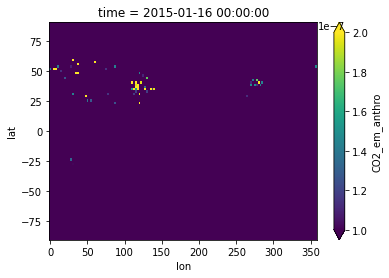

In [8]:
# Get an example emissions dataset to check it's working
coarse_emissions = regridder(example_input4MIPs_ds['CO2_em_anthro'])

print(coarse_emissions.sel(time='2015-01').sum().compute())
coarse_emissions.sel(time='2015-01').squeeze().plot.pcolormesh(vmin=1e-7, vmax=2e-7)

<xarray.DataArray 'CO2_em_anthro' ()>
array(0.00050094, dtype=float32)


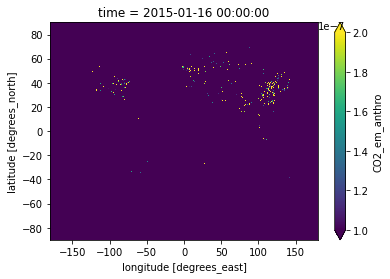

In [9]:
print(example_input4MIPs_ds.sel(time='2015-01')['CO2_em_anthro'].sum().compute())
example_input4MIPs_ds.sel(time='2015-01')['CO2_em_anthro'].squeeze().plot.pcolormesh(vmin=1e-7, vmax=2e-7)

# Get input4MIPS

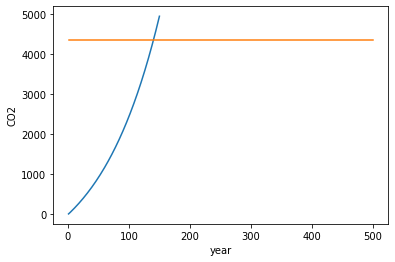

In [10]:
# Deal with CMIP experiments

# get the baseline CO2 mass from piControl

# CO2 mass in kg
baseline_co2_mass = xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_piControl*.nc')['co2mass'].mean()

# 1pctCO2

# (additional) CO2 mass in kg
co2_ts = (xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_1pctCO2*.nc')['co2mass'].groupby('time.year').mean() - baseline_co2_mass).rename('CO2')  * 1e-12 # kg -> Gt
so2_ts = xr.zeros_like(co2_ts).rename('SO2')
ch4_ts = xr.zeros_like(co2_ts).rename('CH4')
bc_ts = xr.zeros_like(co2_ts).rename('BC')

co2_ts.plot()

ds = xr.merge([co2_ts, so2_ts, ch4_ts, bc_ts])
ds.rename({'year': 'time'}).to_netcdf(output_path+'inputs_1pctCO2.nc')

# abrupt-4xCO2

# (additional) CO2 mass in kg
co2_ts = (xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_abrupt-4xCO2*.nc')['co2mass'].groupby('time.year').mean() - baseline_co2_mass).rename('CO2')  * 1e-12 # kg -> Gt
so2_ts = xr.zeros_like(co2_ts).rename('SO2')
ch4_ts = xr.zeros_like(co2_ts).rename('CH4')
bc_ts = xr.zeros_like(co2_ts).rename('BC')

co2_ts.plot()
ds = xr.merge([co2_ts, so2_ts, ch4_ts, bc_ts])
ds.rename({'year': 'time'}).to_netcdf(output_path+'inputs_abrupt-4xCO2.nc')


In [11]:
# Use the global checksums
all_files = glob(input_path+'/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_*.csv')
#all_files=glob(input_path+'/CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP*.nc')
print(all_files)
co2_air=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in all_files)) 
co2_air=co2_air.groupby(level=['year']).sum() / 1e6 # kt -> Gt
all_files = glob(input_path+'/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_*.csv')
co2=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in all_files)) 
co2=co2.groupby(level=['year']).sum() / 1e6 # kt -> Gt
# ckeck starting year of csv file, might need to skip the first 100 years
co2_tot = (co2_air + co2)[100:]
co2_tot

['/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185001-185012.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_175001-179912.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv', '/home/charlie/Documents/MILA/ClimateBench/climate_bench_inputs/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017

,global_total
year,
1850,0.188297
1851,0.188947
1852,0.196570
1853,0.205034
1854,0.241471
...,...
2010,32.892259
2011,33.919973
2012,34.398774


In [12]:
# Use the global checksums
all_files = glob(input_path+'/CH4-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.csv')
ch4=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']).rename(columns={'value': 'global_total'}) for f in all_files)) 
# Fill in the data up to 1970
ch4 = ch4.groupby(level=['year']).sum().reindex(range(1850, 2015)).interpolate('linear') / 1e6 # kt -> Gt
# Note the AIR component for methane is zero over the historical period
ch4

,global_total
year,
1850,0.031306
1851,0.031742
1852,0.032178
1853,0.032614
1854,0.033049
...,...
2010,0.357019
2011,0.360551
2012,0.366511


In [13]:
hist_co2_ts = xr.DataArray(co2_tot.cumsum()['global_total'], name='CO2')

In [14]:
print(hist_co2_ts
     )

<xarray.DataArray 'CO2' (year: 165)>
array([1.88297189e-01, 3.77244499e-01, 5.73814120e-01, 7.78848498e-01,
       1.02031959e+00, 1.26422731e+00, 1.52512019e+00, 1.78857170e+00,
       2.05617947e+00, 2.34146436e+00, 2.65589507e+00, 2.98729869e+00,
       3.32393522e+00, 3.68117679e+00, 4.06493643e+00, 4.47145662e+00,
       4.89190972e+00, 5.34110502e+00, 5.80139408e+00, 6.28983370e+00,
       6.79066964e+00, 7.32292739e+00, 7.91050857e+00, 8.53381433e+00,
       9.12383651e+00, 9.75873506e+00, 1.04034513e+01, 1.10624116e+01,
       1.17248591e+01, 1.24327402e+01, 1.32364998e+01, 1.40618181e+01,
       1.49301050e+01, 1.58494950e+01, 1.67760499e+01, 1.77084426e+01,
       1.86550648e+01, 1.96480320e+01, 2.07437896e+01, 2.18409098e+01,
       2.30329028e+01, 2.42804778e+01, 2.55371854e+01, 2.67752933e+01,
       2.80619702e+01, 2.94240890e+01, 3.08300447e+01, 3.23030831e+01,
       3.38542587e+01, 3.55520596e+01, 3.73408806e+01, 3.91895421e+01,
       4.10926558e+01, 4.31684005e+01, 4

In [15]:
hist_so2_ts = regridder(xr.open_mfdataset(input_path+'/SO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.nc')['SO2_em_anthro'].sum('sector').groupby('time.year').mean().sel(year=slice(1850, None)).rename('SO2'))
print(hist_so2_ts)

<xarray.DataArray 'SO2' (year: 165, lat: 96, lon: 144)>
dask.array<transpose, shape=(165, 96, 144), dtype=float64, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear


/home/charlie/miniconda3/envs/climatebench_data/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [16]:
hist_ch4_ts = xr.DataArray(ch4['global_total'], name='CH4')
print(hist_ch4_ts)

<xarray.DataArray 'CH4' (year: 165)>
array([0.03130595, 0.03174183, 0.03217772, 0.0326136 , 0.03304948,
       0.03348537, 0.03392125, 0.03435714, 0.03479302, 0.03522891,
       0.03566479, 0.03660865, 0.0375525 , 0.03849636, 0.03944021,
       0.04038407, 0.04132793, 0.04227178, 0.04321564, 0.04415949,
       0.04510335, 0.04608819, 0.04707303, 0.04805787, 0.04904271,
       0.05002755, 0.05101239, 0.05199723, 0.05298207, 0.05396691,
       0.05495175, 0.05598158, 0.05701142, 0.05804125, 0.05907108,
       0.06010092, 0.06113075, 0.06216059, 0.06319042, 0.06422025,
       0.06525009, 0.06632685, 0.06740362, 0.06848039, 0.06955716,
       0.07063393, 0.0717107 , 0.07278746, 0.07386423, 0.074941  ,
       0.07601777, 0.07701439, 0.07801102, 0.07900765, 0.08000427,
       0.0810009 , 0.08199752, 0.08299415, 0.08399077, 0.0849874 ,
       0.08598402, 0.08712906, 0.08827409, 0.08941913, 0.09056416,
       0.0917092 , 0.09285423, 0.09399927, 0.0951443 , 0.09628934,
       0.09743437, 0.0984

In [17]:
#hist_bc_ts = regridder(xr.open_mfdataset(input_path+'/BC-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.nc')['BC_em_anthro'].sum('sector').groupby('time.year').mean().sel(year=slice(1850, None)).rename('BC'))
hist_bc_ts = regridder(xr.open_mfdataset(input_path+'/BC-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.nc')['BC_em_anthro'].sum('sector').groupby('time.year').mean().sel(year=slice(1850, None)).rename('BC'))
rint(hist_bc_ts)

/home/charlie/miniconda3/envs/climatebench_data/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


so2
<xarray.DataArray 'BC' (year: 165, lat: 96, lon: 144)>
dask.array<transpose, shape=(165, 96, 144), dtype=float64, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear
<xarray.DataArray 'SO2' (year: 165, lat: 96, lon: 144)>
dask.array<transpose, shape=(165, 96, 144), dtype=float64, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear


/home/charlie/miniconda3/envs/climatebench_data/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [19]:
ds1=xr.merge([hist_so2_ts, hist_bc_ts], fill_value=0.)
print(ds1)

<xarray.Dataset>
Dimensions:  (year: 165, lon: 144, lat: 96)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    SO2      (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    BC       (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear


In [21]:
ds2=xr.merge([hist_co2_ts, hist_ch4_ts], fill_value=0.)  # Set a fill value to set the methane to zero before 1970..
print(ds2)

<xarray.Dataset>
Dimensions:  (year: 165)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Data variables:
    CO2      (year) float64 0.1883 0.3772 0.5738 ... 1.429e+03 1.465e+03 1.5e+03
    CH4      (year) float64 0.03131 0.03174 0.03218 ... 0.3665 0.3698 0.3712


In [22]:
ds=xr.merge([ds1, ds2])
print(ds)

<xarray.Dataset>
Dimensions:  (year: 165, lon: 144, lat: 96)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    SO2      (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    BC       (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CO2      (year) float64 0.1883 0.3772 0.5738 ... 1.429e+03 1.465e+03 1.5e+03
    CH4      (year) float64 0.03131 0.03174 0.03218 ... 0.3665 0.3698 0.3712
Attributes:
    regrid_method:  bilinear


In [ ]:
# historical
# Fix some metadata to help iris
# changed ds.latitude into ds.lat 
ds.lat.attrs['units'] = 'degrees' 
print(ds)
ds.rename({'year': 'time'})
print(ds)
ds.to_netcdf(output_path+'inputs_historical.nc')

<xarray.Dataset>
Dimensions:  (year: 165, lon: 144, lat: 96)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    SO2      (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    BC       (year, lat, lon) float64 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CO2      (year) float64 0.1883 0.3772 0.5738 ... 1.429e+03 1.465e+03 1.5e+03
    CH4      (year) float64 0.03131 0.03174 0.03218 ... 0.3665 0.3698 0.3712
Attributes:
    regrid_method:  bilinear
<xarray.Dataset>
Dimensions:  (year: 165, lon: 144, lat: 96)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 

In [ ]:
# Deal with DAMIP experiments
'hist-GHG', 'hist-aer', 'hist-nat', 'hist-piAer', 'hist-piNTCF'

# hist-GHG
# Time varying global annual mean concentrations for CO2 and other long-lived greenhouse-gases 
# https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=hist-ghg

ds = xr.merge([hist_co2_ts, 
               hist_ch4_ts, 
               xr.zeros_like(hist_bc_ts).rename('BC'),
               xr.zeros_like(hist_so2_ts).rename('SO2'),
              ])
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_hist-GHG.nc')

# hist-aer
# forced by changes in anthropogenic aerosol forcing only 
# https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=hist-aer

ds = xr.merge([xr.zeros_like(hist_co2_ts).rename('CO2'), 
               xr.zeros_like(hist_ch4_ts).rename('CH4'), 
               hist_bc_ts,
               hist_so2_ts,
              ])
# Fix some metadata to help iris
ds.latitude.attrs['units'] = 'degrees'    
print(ds)
ds.rename({'year': 'time'}).to_netcdf(output_path+'inputs_hist-aer.nc')



In [ ]:
for exp in experiments:
    print(exp)
    
    # According to email from Dirk on 14th December the NorESM2 simulations on ESGF
    #  used the ssp370 GHG emissions for ssp370-lowNTCF (as per the AerChemMIP spec, but not the input4MIPS files)
    if exp == 'ssp370-lowNTCF':
        GHG_exp = 'ssp370'
    else:
        GHG_exp = exp
        
    co2_files = glob(path_f_csv.format(species="CO2", scenario=GHG_exp))
    co2=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in co2_files)).groupby(level=['year']).sum() / 1e6
    # Get the CO2 emissions
    co2_ts = xr.DataArray(co2['global_total'], name='CO2')

    so2_f = path_f.format(species="SO2", scenario=exp)
    so2_da = xr.open_mfdataset(so2_f, combine='by_coords')['SO2_em_anthro']
    # Get a the current SO2 emissions
    so2_ts = regridder(so2_da.sum('sector').groupby('time.year').mean())
    
    ch4_files = glob(path_f_csv.format(species="CH4", scenario=GHG_exp))
    ch4=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in ch4_files)).groupby(level=['year']).sum() / 1e3 # The SSP data is in Mt 
    # Get the current CH4 emissions
    ch4_ts = xr.DataArray(ch4['value'], name='CH4')
    
    bc_f = path_f.format(species="BC", scenario=exp, chunks=None)
    # Get a the current BC emissions
    bc_da = xr.open_mfdataset(bc_f, combine='by_coords')['BC_em_anthro']
    bc_ts = regridder(bc_da.sum('sector').groupby('time.year').mean())
    
    # These come in monthly means every 5 years, so take the annual mean then interpolate to every year
    years = list(range(2015, 2101))

    ds = xr.merge([co2_ts.rename('CO2'), so2_ts.rename('SO2'), ch4_ts.rename('CH4'), bc_ts.rename('BC')]).interp(year=years, method='linear')
    
    # Convert the CO2 emissions to *cumulative* CO2 mass in atmosphere. Do this *after* interpolating on to yearly to get the right totals.
    ds['CO2'] = ds['CO2'].cumsum() + hist_co2_ts[-1]  # Be sure to add the current total in 2015
    ds['CH4'].plot(label=exp)

    # Fix some metadata to help iris
    ds.latitude.attrs['units'] = 'degrees'    
#     print(ds)
    ds.rename({'year': 'time'}).to_netcdf(output_path+f"inputs_{exp}.nc")
    
plt.legend()

# Pull down the timeslice ERF values in case they're useful

In [ ]:
erf_df = pd.read_csv('https://raw.githubusercontent.com/chrisroadmap/aerosol-history/main/data_input/RFMIP-ERF-tier2.csv', index_col=0)
noresm_erf_df = erf_df.loc[:2014, erf_df.columns.str.startswith('NorESM2-LM')]
noresm_erf_df.columns = noresm_erf_df.columns.str.replace("NorESM2-LM ", "")
print(noresm_erf_df)
noresm_erf_df.to_csv('inputs_NorESM2_ERF.csv')

In [ ]:
# These might also be useful: https://github.com/njleach/GIR/tree/master/GIR/Parameter_Sets

# Merge ensemble members (for target data)

In [ ]:
target_path="/home/charlie/Documents/MILA/ClimateBench/target_data/data/"

In [ ]:
experiments = [
               '1pctCO2', 'abrupt-4xCO2', 'historical', 'piControl', # CMIP
               'hist-GHG', 'hist-aer', # DAMIP
               'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF', 'ssp585' #	ScenarioMIP
]

def preprocess(ds):
    """
    Promote the ensemble member attribute to a coord
    """
    return ds.assign_coords(member=("member", [ds.attrs['source'].split('_')[2]]))

# Subtract baseline values
baseline = xr.open_dataset(f"NorESM2-LM_piControl_r1i1p1f1.nc").mean('year')

for exp in experiments:
    files=list(glob(f"{target_path}NorESM2-LM_{exp}_*"))# add path to target data
    print(files)
    ens_ds = []
    for f in files:
        
        # change split: assuming we want to have what's behind the r
        g=f.split('_')[-1][1]
        print(g)
        print('member', g)
        ds = xr.open_dataset(f)
        ds['member'] = g#[int(f.split('_')[2][1])]
        ds.assign_coords(member="member")
        ens_ds.append(ds)
    en_ds = xr.concat(ens_ds, dim='member')
    if exp != "piControl":
        en_ds = en_ds - baseline
    # Fix some metadata to help iris
    en_ds.lat.attrs['units'] = 'degrees'
    en_ds = en_ds.rename({'year': 'time'})
    print(en_ds)
    # For some reason these runs go until 2020
    if exp.startswith("hist-"):
        en_ds = en_ds.sel(time=slice(None, 2014))
        
    if exp == '1pctCO2':
        print(en_ds['diurnal_temperature_range'])
    en_ds.to_netcdf(output_path+f'outputs_{exp}.nc')

# Create the tar-balls

In [ ]:
def make_tarfile(output_filename, files):
    with tarfile.open(output_filename, "w:gz") as tar:
        for f in files:
            tar.add(f)

train_val_files = [f"inputs_{exp}.nc" for exp in experiments if exp not in ["ssp245", "piControl"]] + [f"outputs_{exp}.nc" for exp in experiments if exp != "ssp245"]
make_tarfile('train_val.tar.gz', train_val_files)
        
test_files = ["inputs_ssp245.nc", "outputs_ssp245.nc"]
make_tarfile('test.tar.gz', test_files)